In [1]:
# Loading the libraries
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import simbench as sb
import pandapower as pp
import pandapower.plotting as plot
from pandapower.timeseries.run_time_series import run_timeseries
from datetime import datetime 

import openpyxl
import lightsim2grid
import numba

pd.set_option('display.max_columns', 30)
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Analysis Scenario 2016

This pandapower network includes the following parameter tables:
   - bus (15 element)
   - load (13 element)
   - sgen (4 element)
   - switch (28 element)
   - ext_grid (1 elements)
   - line (13 element)
   - trafo (1 elements)
   - bus_geodata (15 element)
   - loadcases (6 element)

The Object is of type <class 'pandapower.auxiliary.pandapowerNet'>

And it looks like this: 


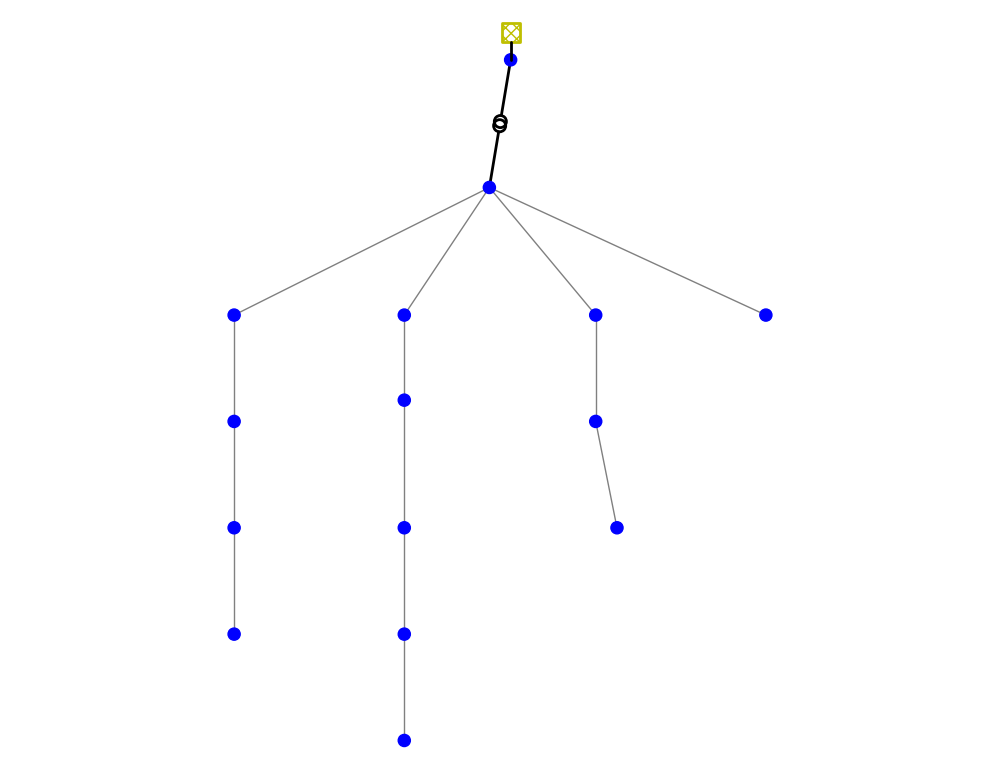

In [2]:
def load_simbench_data(scenario):
    """
    Loads SimBench data for a specified scenario.

    Parameters:
    - scenario: int. The scenario number (0, 1, or 2) for which to load data.

    Returns:
    - net: The SimBench network for the specified scenario.
    - date: The date range for the specified scenario.
    """
    # Determine the analysis scenario
    if scenario == 0:
        print('Analysis Scenario 2016')
        date = pd.date_range('2016-01-01 00:00:00', '2016-12-31 23:45:00', freq='15min')
    elif scenario == 1:
        print('Analysis Scenario 2024')
        date = pd.date_range('2024-01-01 00:00:00', '2024-12-31 23:45:00', freq='15min')
    elif scenario == 2:
        print('Analysis Scenario 2034')
        date = pd.date_range('2034-01-01 00:00:00', '2034-12-31 23:45:00', freq='15min')
    else:
        raise ValueError("Invalid scenario number. Please choose 0, 1, or 2.")

    # Load the network
    test_net = f'1-LV-rural1--0-sw{scenario}'  # Adjust this pattern as needed
    net = sb.get_simbench_net(test_net)
    
    print("")
    print(net)
    print("")
    print(f"The Object is of type {type(net)}")
    print("")
    print("And it looks like this: ")
    plot.simple_plot(net)
    return net, date


# Load the network using load_scenarios function
scenario = 0  # Change this to 1 or 2 to test other scenarios
net, date = load_simbench_data(scenario)

In [3]:
# What is the type of the object net?
print(f"The Object is of type {type(net)}")


The Object is of type <class 'pandapower.auxiliary.pandapowerNet'>


## Generate Core Dataset

In [4]:
profiles = sb.get_absolute_values(net, profiles_instead_of_study_cases=True)

load_p = profiles['load', 'p_mw']
load_q = profiles['load', 'q_mvar']
sgen_p = profiles['sgen', 'p_mw']

load_p.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.001926,0.000711,0.000721,0.000132,0.001284,0.000433,0.001154,0.004495,0.000963,0.001731,0.000553,0.000577,0.004495
1,0.001905,0.000201,0.002083,0.000381,0.001270,0.001250,0.003333,0.004446,0.000953,0.005000,0.000132,0.001667,0.004446
2,0.002505,0.000191,0.002092,0.000336,0.001670,0.001255,0.003347,0.005846,0.001253,0.005021,0.000413,0.001674,0.005846
3,0.002242,0.000196,0.002404,0.000227,0.001495,0.001442,0.003846,0.005232,0.001121,0.005769,0.000256,0.001923,0.005232
4,0.002463,0.000228,0.002274,0.000269,0.001642,0.001364,0.003638,0.005747,0.001232,0.005457,0.000216,0.001819,0.005747


In [6]:
# get the bus number from net.load and add it to load_p as header
load_p.columns = net.load.bus
load_q.columns = net.load.bus
sgen_p.columns = net.sgen.bus

# Rename the columns to the bus names
load_p.columns = net.bus.loc[load_p.columns, 'name']
load_q.columns = net.bus.loc[load_q.columns, 'name']
sgen_p.columns = net.bus.loc[sgen_p.columns, 'name']

# Rename the columns to the following structure: 'load_name'
load_p.columns = [f'load_p_{col}' for col in load_p.columns]
load_q.columns = [f'load_q_{col}' for col in load_q.columns]
sgen_p.columns = [f'sgen_p_{col}' for col in sgen_p.columns]


In [7]:
load_p.head()

,load_p_LV1.101 Bus 10,load_p_LV1.101 Bus 8,load_p_LV1.101 Bus 14,load_p_LV1.101 Bus 13,load_p_LV1.101 Bus 9,load_p_LV1.101 Bus 6,load_p_LV1.101 Bus 3,load_p_LV1.101 Bus 1,load_p_LV1.101 Bus 7,load_p_LV1.101 Bus 12,load_p_LV1.101 Bus 11,load_p_LV1.101 Bus 2,load_p_LV1.101 Bus 5
0,0.001926,0.000711,0.000721,0.000132,0.001284,0.000433,0.001154,0.004495,0.000963,0.001731,0.000553,0.000577,0.004495
1,0.001905,0.000201,0.002083,0.000381,0.001270,0.001250,0.003333,0.004446,0.000953,0.005000,0.000132,0.001667,0.004446
2,0.002505,0.000191,0.002092,0.000336,0.001670,0.001255,0.003347,0.005846,0.001253,0.005021,0.000413,0.001674,0.005846
3,0.002242,0.000196,0.002404,0.000227,0.001495,0.001442,0.003846,0.005232,0.001121,0.005769,0.000256,0.001923,0.005232
4,0.002463,0.000228,0.002274,0.000269,0.001642,0.001364,0.003638,0.005747,0.001232,0.005457,0.000216,0.001819,0.005747


In [8]:
# Determine the start date based on the scenario
if scenario == 0:
    start_date = '2016-01-01 00:00:00'
elif scenario == 1:
    start_date = '2024-01-01 00:00:00'
elif scenario == 2:
    start_date = '2034-01-01 00:00:00'
else:
    raise ValueError("Invalid scenario number. Please check your scenario setting")

# Generate a datetime index and assign it to each dataframe
date_range = pd.date_range(start=start_date, periods=len(load_p), freq='15min')
load_p['datetime'] = date_range
load_q['datetime'] = date_range
sgen_p['datetime'] = date_range


# Set the datetime column as the index for each dataframe
load_p.set_index('datetime', inplace=True)
load_q.set_index('datetime', inplace=True)
sgen_p.set_index('datetime', inplace=True)

In [9]:
sgen_p.head()

,sgen_p_LV1.101 Bus 7,sgen_p_LV1.101 Bus 11,sgen_p_LV1.101 Bus 8,sgen_p_LV1.101 Bus 13
datetime,,,,
2016-01-01 00:00:00,0.0,0.0,0.0,0.0
2016-01-01 00:15:00,0.0,0.0,0.0,0.0
2016-01-01 00:30:00,0.0,0.0,0.0,0.0
2016-01-01 00:45:00,0.0,0.0,0.0,0.0
2016-01-01 01:00:00,0.0,0.0,0.0,0.0


In [10]:
# Load 240218_Combined_Load_And_TrafoData.csv if dataframe combined is not available in memory 

if 'Combined_Load_And_TrafoData' not in locals():
    print('Data not in memory')
    print('Loading Combined_Load_And_TrafoData.csv...')
    Combined_Load_And_TrafoData = pd.read_csv('240218_Combined_Load_And_TrafoData.csv', index_col=0, parse_dates=True)
elif 'Combined_Load_And_TrafoData' in locals():
    print('Data already in memory')
    pass

print('Data is now availlable in the variable Combined_Load_And_TrafoData')

Data not in memory
Loading Combined_Load_And_TrafoData.csv...
Data is now availlable in the variable Combined_Load_And_TrafoData


In [11]:
Combined_Load_And_TrafoData.head()

# Make the index a normal column
Combined_Load_And_TrafoData.reset_index(inplace=True)

Combined_Load_And_TrafoData.head()

,datetime,trafo_p_hv_mw,trafo_q_hv_mvar,trafo_p_lv_mw,trafo_q_lv_mvar,trafo_pl_mw,trafo_ql_mvar,trafo_i_hv_ka,trafo_i_lv_ka,trafo_vm_hv_pu,trafo_va_hv_degree,trafo_vm_lv_pu,trafo_va_lv_degree,trafo_loading_percent,load_0,...,load_5,load_6,load_7,load_8,load_9,load_10,load_11,load_12,year,quarter,month,day,hour,day_of_week,is_weekend
0,2016-01-01 00:00:00,-0.138606,0.036278,0.140890,-0.031716,0.002285,0.004562,0.004035,0.202417,1.025,0.0,1.029791,1.933737,87.648978,0.001926,...,0.000433,0.001154,0.004495,0.000963,0.001731,0.000553,0.000577,0.004495,2016,1,1,1,0,4,0
1,2016-01-01 00:15:00,-0.130922,0.035803,0.133022,-0.031707,0.002100,0.004096,0.003823,0.191789,1.025,0.0,1.029152,1.835468,83.047229,0.001905,...,0.001250,0.003333,0.004446,0.000953,0.005000,0.000132,0.001667,0.004446,2016,1,1,1,0,4,0
2,2016-01-01 00:30:00,-0.126639,0.035554,0.128641,-0.031707,0.002002,0.003847,0.003704,0.185882,1.025,0.0,1.028794,1.780720,80.489240,0.002505,...,0.001255,0.003347,0.005846,0.001253,0.005021,0.000413,0.001674,0.005846,2016,1,1,1,0,4,0
3,2016-01-01 00:45:00,-0.126705,0.035556,0.128708,-0.031706,0.002003,0.003851,0.003706,0.185972,1.025,0.0,1.028799,1.781552,80.528190,0.002242,...,0.001442,0.003846,0.005232,0.001121,0.005769,0.000256,0.001923,0.005232,2016,1,1,1,0,4,0
4,2016-01-01 01:00:00,-0.126007,0.035517,0.127994,-0.031706,0.001988,0.003811,0.003687,0.185010,1.025,0.0,1.028741,1.772634,80.111883,0.002463,...,0.001364,0.003638,0.005747,0.001232,0.005457,0.000216,0.001819,0.005747,2016,1,1,1,1,4,0


In [12]:
# Remove all columns which begins with load_
load_cols = [col for col in Combined_Load_And_TrafoData.columns if col.startswith('load_')]
Combined_Load_And_TrafoData.drop(columns=load_cols, inplace=True)

Combined_Load_And_TrafoData.head()

,datetime,trafo_p_hv_mw,trafo_q_hv_mvar,trafo_p_lv_mw,trafo_q_lv_mvar,trafo_pl_mw,trafo_ql_mvar,trafo_i_hv_ka,trafo_i_lv_ka,trafo_vm_hv_pu,trafo_va_hv_degree,trafo_vm_lv_pu,trafo_va_lv_degree,trafo_loading_percent,year,quarter,month,day,hour,day_of_week,is_weekend
0,2016-01-01 00:00:00,-0.138606,0.036278,0.140890,-0.031716,0.002285,0.004562,0.004035,0.202417,1.025,0.0,1.029791,1.933737,87.648978,2016,1,1,1,0,4,0
1,2016-01-01 00:15:00,-0.130922,0.035803,0.133022,-0.031707,0.002100,0.004096,0.003823,0.191789,1.025,0.0,1.029152,1.835468,83.047229,2016,1,1,1,0,4,0
2,2016-01-01 00:30:00,-0.126639,0.035554,0.128641,-0.031707,0.002002,0.003847,0.003704,0.185882,1.025,0.0,1.028794,1.780720,80.489240,2016,1,1,1,0,4,0
3,2016-01-01 00:45:00,-0.126705,0.035556,0.128708,-0.031706,0.002003,0.003851,0.003706,0.185972,1.025,0.0,1.028799,1.781552,80.528190,2016,1,1,1,0,4,0
4,2016-01-01 01:00:00,-0.126007,0.035517,0.127994,-0.031706,0.001988,0.003811,0.003687,0.185010,1.025,0.0,1.028741,1.772634,80.111883,2016,1,1,1,1,4,0


In [13]:
# Merge Combined_Load_And_TrafoData with load_p, load_q, and sgen_p
Combined_Load_And_TrafoData = pd.merge(Combined_Load_And_TrafoData, load_p, left_on='datetime', right_index=True)
Combined_Load_And_TrafoData = pd.merge(Combined_Load_And_TrafoData, load_q, left_on='datetime', right_index=True)
Combined_Load_And_TrafoData = pd.merge(Combined_Load_And_TrafoData, sgen_p, left_on='datetime', right_index=True)


In [14]:
Combined_Load_And_TrafoData.head()

# Save the dataframe to a csv file
#Combined_Load_And_TrafoData.to_csv('240226_Combined_Load_And_TrafoData.csv')

,datetime,trafo_p_hv_mw,trafo_q_hv_mvar,trafo_p_lv_mw,trafo_q_lv_mvar,trafo_pl_mw,trafo_ql_mvar,trafo_i_hv_ka,trafo_i_lv_ka,trafo_vm_hv_pu,trafo_va_hv_degree,trafo_vm_lv_pu,trafo_va_lv_degree,trafo_loading_percent,year,...,load_q_LV1.101 Bus 14,load_q_LV1.101 Bus 13,load_q_LV1.101 Bus 9,load_q_LV1.101 Bus 6,load_q_LV1.101 Bus 3,load_q_LV1.101 Bus 1,load_q_LV1.101 Bus 7,load_q_LV1.101 Bus 12,load_q_LV1.101 Bus 11,load_q_LV1.101 Bus 2,load_q_LV1.101 Bus 5,sgen_p_LV1.101 Bus 7,sgen_p_LV1.101 Bus 11,sgen_p_LV1.101 Bus 8,sgen_p_LV1.101 Bus 13
0,2016-01-01 00:00:00,-0.138606,0.036278,0.140890,-0.031716,0.002285,0.004562,0.004035,0.202417,1.025,0.0,1.029791,1.933737,87.648978,2016,...,0.000248,-0.000011,0.000516,0.000149,0.000397,0.001806,0.000387,0.000595,-0.000053,0.000198,0.001806,0.0,0.0,0.0,0.0
1,2016-01-01 00:15:00,-0.130922,0.035803,0.133022,-0.031707,0.002100,0.004096,0.003823,0.191789,1.025,0.0,1.029152,1.835468,83.047229,2016,...,0.001161,0.000168,0.000547,0.000697,0.001858,0.001916,0.000411,0.002786,0.000048,0.000929,0.001916,0.0,0.0,0.0,0.0
2,2016-01-01 00:30:00,-0.126639,0.035554,0.128641,-0.031707,0.002002,0.003847,0.003704,0.185882,1.025,0.0,1.028794,1.780720,80.489240,2016,...,0.001199,0.000048,0.000628,0.000720,0.001919,0.002199,0.000471,0.002878,0.000059,0.000959,0.002199,0.0,0.0,0.0,0.0
3,2016-01-01 00:45:00,-0.126705,0.035556,0.128708,-0.031706,0.002003,0.003851,0.003706,0.185972,1.025,0.0,1.028799,1.781552,80.528190,2016,...,0.001219,0.000008,0.000625,0.000732,0.001951,0.002186,0.000469,0.002927,0.000008,0.000976,0.002186,0.0,0.0,0.0,0.0
4,2016-01-01 01:00:00,-0.126007,0.035517,0.127994,-0.031706,0.001988,0.003811,0.003687,0.185010,1.025,0.0,1.028741,1.772634,80.111883,2016,...,0.001243,0.000020,0.000554,0.000746,0.001989,0.001940,0.000416,0.002983,0.000020,0.000994,0.001940,0.0,0.0,0.0,0.0


In [15]:
# Melting the dataframe
id_vars = ['datetime', 'day_of_week', 'is_weekend', 'year', 'quarter', 'month', 'day', 'hour']
value_vars = [col for col in Combined_Load_And_TrafoData.columns if col not in id_vars]

melted_df = pd.melt(Combined_Load_And_TrafoData, id_vars=id_vars, value_vars=value_vars,
                    var_name='Variable', value_name='Value')

melted_df.head()

,datetime,day_of_week,is_weekend,year,quarter,month,day,hour,Variable,Value
0,2016-01-01 00:00:00,4,0,2016,1,1,1,0,trafo_p_hv_mw,-0.138606
1,2016-01-01 00:15:00,4,0,2016,1,1,1,0,trafo_p_hv_mw,-0.130922
2,2016-01-01 00:30:00,4,0,2016,1,1,1,0,trafo_p_hv_mw,-0.126639
3,2016-01-01 00:45:00,4,0,2016,1,1,1,0,trafo_p_hv_mw,-0.126705
4,2016-01-01 01:00:00,4,0,2016,1,1,1,1,trafo_p_hv_mw,-0.126007


In [16]:
# List all Variables
melted_df.Variable.unique()

array(['trafo_p_hv_mw', 'trafo_q_hv_mvar', 'trafo_p_lv_mw',
       'trafo_q_lv_mvar', 'trafo_pl_mw', 'trafo_ql_mvar', 'trafo_i_hv_ka',
       'trafo_i_lv_ka', 'trafo_vm_hv_pu', 'trafo_va_hv_degree',
       'trafo_vm_lv_pu', 'trafo_va_lv_degree', 'trafo_loading_percent',
       'load_p_LV1.101 Bus 10', 'load_p_LV1.101 Bus 8',
       'load_p_LV1.101 Bus 14', 'load_p_LV1.101 Bus 13',
       'load_p_LV1.101 Bus 9', 'load_p_LV1.101 Bus 6',
       'load_p_LV1.101 Bus 3', 'load_p_LV1.101 Bus 1',
       'load_p_LV1.101 Bus 7', 'load_p_LV1.101 Bus 12',
       'load_p_LV1.101 Bus 11', 'load_p_LV1.101 Bus 2',
       'load_p_LV1.101 Bus 5', 'load_q_LV1.101 Bus 10',
       'load_q_LV1.101 Bus 8', 'load_q_LV1.101 Bus 14',
       'load_q_LV1.101 Bus 13', 'load_q_LV1.101 Bus 9',
       'load_q_LV1.101 Bus 6', 'load_q_LV1.101 Bus 3',
       'load_q_LV1.101 Bus 1', 'load_q_LV1.101 Bus 7',
       'load_q_LV1.101 Bus 12', 'load_q_LV1.101 Bus 11',
       'load_q_LV1.101 Bus 2', 'load_q_LV1.101 Bus 5',
    

In [17]:
# Remove all variables that are not needed:
#    'trafo_q_lv_mvar', 'trafo_pl_mw', 'trafo_ql_mvar', 'trafo_i_hv_ka',
#      'trafo_i_lv_ka', 'trafo_vm_hv_pu', 'trafo_va_hv_degree',
#      'trafo_vm_lv_pu', 'trafo_va_lv_degree'

melted_df = melted_df[~melted_df.Variable.isin(['trafo_q_lv_mvar', 'trafo_pl_mw', 'trafo_ql_mvar', 'trafo_i_hv_ka',
                                                'trafo_i_lv_ka', 'trafo_vm_hv_pu', 'trafo_va_hv_degree',
                                                'trafo_vm_lv_pu', 'trafo_va_lv_degree'])]

melted_df.Variable.unique()

array(['trafo_p_hv_mw', 'trafo_q_hv_mvar', 'trafo_p_lv_mw',
       'trafo_loading_percent', 'load_p_LV1.101 Bus 10',
       'load_p_LV1.101 Bus 8', 'load_p_LV1.101 Bus 14',
       'load_p_LV1.101 Bus 13', 'load_p_LV1.101 Bus 9',
       'load_p_LV1.101 Bus 6', 'load_p_LV1.101 Bus 3',
       'load_p_LV1.101 Bus 1', 'load_p_LV1.101 Bus 7',
       'load_p_LV1.101 Bus 12', 'load_p_LV1.101 Bus 11',
       'load_p_LV1.101 Bus 2', 'load_p_LV1.101 Bus 5',
       'load_q_LV1.101 Bus 10', 'load_q_LV1.101 Bus 8',
       'load_q_LV1.101 Bus 14', 'load_q_LV1.101 Bus 13',
       'load_q_LV1.101 Bus 9', 'load_q_LV1.101 Bus 6',
       'load_q_LV1.101 Bus 3', 'load_q_LV1.101 Bus 1',
       'load_q_LV1.101 Bus 7', 'load_q_LV1.101 Bus 12',
       'load_q_LV1.101 Bus 11', 'load_q_LV1.101 Bus 2',
       'load_q_LV1.101 Bus 5', 'sgen_p_LV1.101 Bus 7',
       'sgen_p_LV1.101 Bus 11', 'sgen_p_LV1.101 Bus 8',
       'sgen_p_LV1.101 Bus 13'], dtype=object)

# Generate Adjacency Matrix

In [18]:
net.line

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service,subnet,max_loading_percent,voltLvl
0,LV1.101 Line 1,NAYY 4x150SE 0.6/1kV,9,2,0.055767,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
1,LV1.101 Line 2,NAYY 4x150SE 0.6/1kV,13,11,0.053576,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
2,LV1.101 Line 3,NAYY 4x150SE 0.6/1kV,6,3,0.049814,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
3,LV1.101 Line 4,NAYY 4x150SE 0.6/1kV,8,1,0.017886,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
4,LV1.101 Line 5,NAYY 4x150SE 0.6/1kV,7,10,0.016089,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
5,LV1.101 Line 6,NAYY 4x150SE 0.6/1kV,10,9,0.024766,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
6,LV1.101 Line 7,NAYY 4x150SE 0.6/1kV,3,7,0.005141,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
7,LV1.101 Line 8,NAYY 4x150SE 0.6/1kV,11,6,0.002147,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
8,LV1.101 Line 9,NAYY 4x150SE 0.6/1kV,5,13,0.137215,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
9,LV1.101 Line 10,NAYY 4x150SE 0.6/1kV,3,0,0.132499,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7


In [19]:
net.bus_geodata

,x,y,coords
0,11.411,53.6407,NaN
1,11.4102,53.6407,NaN
2,11.4085,53.6392,NaN
3,11.4097,53.6413,NaN
4,11.4093,53.6387,NaN
5,11.4093,53.6392,NaN
6,11.4093,53.6407,NaN
7,11.4085,53.6407,NaN
8,11.4102,53.6402,NaN
9,11.4085,53.6397,NaN


Nodes

In [20]:
# Create a new datafra,e called busInfos which is a combination of net.bus and net.bus_geodata
busInfos = pd.concat([net.bus, net.bus_geodata], axis=1)

# Rename name to node_name
busInfos.rename(columns={'name': 'node_name'}, inplace=True)

# Rename x to longitude and y to latitude
busInfos.rename(columns={'x': 'longitude', 'y': 'latitude'}, inplace=True)

# Save the dataframe busInfos in a new dataframe called nodes
nodes = busInfos.copy()

# Drop the columns which contains only Nan
nodes.dropna(axis=1, how='all', inplace=True)

nodes


,node_name,vn_kv,type,in_service,max_vm_pu,min_vm_pu,subnet,voltLvl,longitude,latitude
0,LV1.101 Bus 1,0.4,b,True,1.100,0.900,LV1.101,7,11.411,53.6407
1,LV1.101 Bus 2,0.4,b,True,1.100,0.900,LV1.101,7,11.4102,53.6407
2,LV1.101 Bus 3,0.4,b,True,1.100,0.900,LV1.101,7,11.4085,53.6392
3,LV1.101 Bus 4,0.4,b,True,1.100,0.900,LV1.101,7,11.4097,53.6413
4,LV1.101 Bus 5,0.4,b,True,1.100,0.900,LV1.101,7,11.4093,53.6387
5,LV1.101 Bus 6,0.4,b,True,1.100,0.900,LV1.101,7,11.4093,53.6392
6,LV1.101 Bus 7,0.4,b,True,1.100,0.900,LV1.101,7,11.4093,53.6407
7,LV1.101 Bus 8,0.4,b,True,1.100,0.900,LV1.101,7,11.4085,53.6407
8,LV1.101 Bus 9,0.4,b,True,1.100,0.900,LV1.101,7,11.4102,53.6402
9,LV1.101 Bus 10,0.4,b,True,1.100,0.900,LV1.101,7,11.4085,53.6397


Edges

In [21]:
net.line

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service,subnet,max_loading_percent,voltLvl
0,LV1.101 Line 1,NAYY 4x150SE 0.6/1kV,9,2,0.055767,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
1,LV1.101 Line 2,NAYY 4x150SE 0.6/1kV,13,11,0.053576,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
2,LV1.101 Line 3,NAYY 4x150SE 0.6/1kV,6,3,0.049814,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
3,LV1.101 Line 4,NAYY 4x150SE 0.6/1kV,8,1,0.017886,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
4,LV1.101 Line 5,NAYY 4x150SE 0.6/1kV,7,10,0.016089,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
5,LV1.101 Line 6,NAYY 4x150SE 0.6/1kV,10,9,0.024766,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
6,LV1.101 Line 7,NAYY 4x150SE 0.6/1kV,3,7,0.005141,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
7,LV1.101 Line 8,NAYY 4x150SE 0.6/1kV,11,6,0.002147,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
8,LV1.101 Line 9,NAYY 4x150SE 0.6/1kV,5,13,0.137215,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
9,LV1.101 Line 10,NAYY 4x150SE 0.6/1kV,3,0,0.132499,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7


In [22]:
# Format edges
e_tuples = list(zip(net.line.from_bus, net.line.to_bus))
e_tuples

[(9, 2),
 (13, 11),
 (6, 3),
 (8, 1),
 (7, 10),
 (10, 9),
 (3, 7),
 (11, 6),
 (5, 13),
 (3, 0),
 (1, 3),
 (12, 8),
 (4, 5)]

In [23]:
# Step 3: Create an undirected Graph object
G = nx.Graph()

# Step 4: Add nodes with attributes
for index, row in nodes.iterrows():
    G.add_node(row['node_name'], longitude=row['longitude'], latitude=row['latitude'])

# Optional Step 5: Add edges if you have relationships defined
# for from_bus, to_bus in e_tuples:
#     G.add_edge(from_bus, to_bus)

# To verify, print out the graph
print(G.nodes(data=True)) 

[('LV1.101 Bus 1', {'longitude': 11.411, 'latitude': 53.6407}), ('LV1.101 Bus 2', {'longitude': 11.4102, 'latitude': 53.6407}), ('LV1.101 Bus 3', {'longitude': 11.4085, 'latitude': 53.6392}), ('LV1.101 Bus 4', {'longitude': 11.4097, 'latitude': 53.6413}), ('LV1.101 Bus 5', {'longitude': 11.4093, 'latitude': 53.6387}), ('LV1.101 Bus 6', {'longitude': 11.4093, 'latitude': 53.6392}), ('LV1.101 Bus 7', {'longitude': 11.4093, 'latitude': 53.6407}), ('LV1.101 Bus 8', {'longitude': 11.4085, 'latitude': 53.6407}), ('LV1.101 Bus 9', {'longitude': 11.4102, 'latitude': 53.6402}), ('LV1.101 Bus 10', {'longitude': 11.4085, 'latitude': 53.6397}), ('LV1.101 Bus 11', {'longitude': 11.4085, 'latitude': 53.6402}), ('LV1.101 Bus 12', {'longitude': 11.4093, 'latitude': 53.6403}), ('LV1.101 Bus 13', {'longitude': 11.4103, 'latitude': 53.6397}), ('LV1.101 Bus 14', {'longitude': 11.4093, 'latitude': 53.6397}), ('MV1.101 Bus 4', {'longitude': 11.4098, 'latitude': 53.6419})]


In [24]:
# Function to find node name by matching the pattern 'LV1.101 Bus ' + number
def find_node_name(number, nodes_df):
    pattern = f"LV1.101 Bus {number}"
    matched_row = nodes_df[nodes_df['node_name'].str.contains(pattern, regex=False)]
    if not matched_row.empty:
        return matched_row.iloc[0]['node_name']
    return None


In [25]:
# Add edges, converting numbers to node names using the find_node_name function
for from_number, to_number in e_tuples:
    from_node_name = find_node_name(from_number, nodes)
    to_node_name = find_node_name(to_number, nodes)
    if from_node_name and to_node_name:  # Ensure both nodes were found
        G.add_edge(from_node_name, to_node_name)

In [26]:
# Print out the graph's nodes and edges to verify
print("Nodes with attributes:")
for node, attrs in G.nodes(data=True):
    print(f"{node}: {attrs}")
print("\nEdges:")
print(G.edges())

Nodes with attributes:
LV1.101 Bus 1: {'longitude': 11.411, 'latitude': 53.6407}
LV1.101 Bus 2: {'longitude': 11.4102, 'latitude': 53.6407}
LV1.101 Bus 3: {'longitude': 11.4085, 'latitude': 53.6392}
LV1.101 Bus 4: {'longitude': 11.4097, 'latitude': 53.6413}
LV1.101 Bus 5: {'longitude': 11.4093, 'latitude': 53.6387}
LV1.101 Bus 6: {'longitude': 11.4093, 'latitude': 53.6392}
LV1.101 Bus 7: {'longitude': 11.4093, 'latitude': 53.6407}
LV1.101 Bus 8: {'longitude': 11.4085, 'latitude': 53.6407}
LV1.101 Bus 9: {'longitude': 11.4102, 'latitude': 53.6402}
LV1.101 Bus 10: {'longitude': 11.4085, 'latitude': 53.6397}
LV1.101 Bus 11: {'longitude': 11.4085, 'latitude': 53.6402}
LV1.101 Bus 12: {'longitude': 11.4093, 'latitude': 53.6403}
LV1.101 Bus 13: {'longitude': 11.4103, 'latitude': 53.6397}
LV1.101 Bus 14: {'longitude': 11.4093, 'latitude': 53.6397}
MV1.101 Bus 4: {'longitude': 11.4098, 'latitude': 53.6419}

Edges:
[('LV1.101 Bus 1', 'LV1.101 Bus 8'), ('LV1.101 Bus 1', 'LV1.101 Bus 3'), ('LV1.1

In [27]:
# Check 
list(G.nodes(data=True))

[('LV1.101 Bus 1', {'longitude': 11.411, 'latitude': 53.6407}),
 ('LV1.101 Bus 2', {'longitude': 11.4102, 'latitude': 53.6407}),
 ('LV1.101 Bus 3', {'longitude': 11.4085, 'latitude': 53.6392}),
 ('LV1.101 Bus 4', {'longitude': 11.4097, 'latitude': 53.6413}),
 ('LV1.101 Bus 5', {'longitude': 11.4093, 'latitude': 53.6387}),
 ('LV1.101 Bus 6', {'longitude': 11.4093, 'latitude': 53.6392}),
 ('LV1.101 Bus 7', {'longitude': 11.4093, 'latitude': 53.6407}),
 ('LV1.101 Bus 8', {'longitude': 11.4085, 'latitude': 53.6407}),
 ('LV1.101 Bus 9', {'longitude': 11.4102, 'latitude': 53.6402}),
 ('LV1.101 Bus 10', {'longitude': 11.4085, 'latitude': 53.6397}),
 ('LV1.101 Bus 11', {'longitude': 11.4085, 'latitude': 53.6402}),
 ('LV1.101 Bus 12', {'longitude': 11.4093, 'latitude': 53.6403}),
 ('LV1.101 Bus 13', {'longitude': 11.4103, 'latitude': 53.6397}),
 ('LV1.101 Bus 14', {'longitude': 11.4093, 'latitude': 53.6397}),
 ('MV1.101 Bus 4', {'longitude': 11.4098, 'latitude': 53.6419})]

# TEST!!!

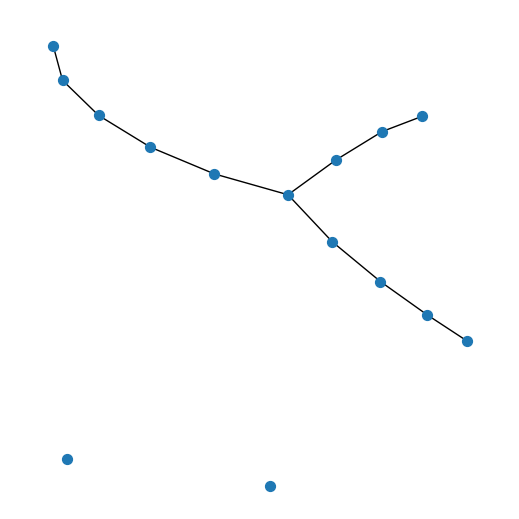

In [28]:
plt.figure(figsize=(5, 5))
nx.draw(G, node_size = 50)
plt.show()

# Remove nodes with no connections to other nodes
G.remove_nodes_from(list(nx.isolates(G)))

# Plot the graph with the corresponding node_name colour coded by name and a legend to visually check it
plt.figure(figsize=(5, 5))
nx.draw(G, node_color = 'lightblue', node_size = 50)
plt.show()



In [29]:
# Get adjacency matrix
adj_mat = nx.adjacency_matrix(G).todense()
adj_mat

array([[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [30]:
# Save
np.save('adj_mat.npy', adj_mat)

In [31]:
np.load('adj_mat.npy')

array([[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

## Add node features

In [32]:
melted_df.head()

,datetime,day_of_week,is_weekend,year,quarter,month,day,hour,Variable,Value
0,2016-01-01 00:00:00,4,0,2016,1,1,1,0,trafo_p_hv_mw,-0.138606
1,2016-01-01 00:15:00,4,0,2016,1,1,1,0,trafo_p_hv_mw,-0.130922
2,2016-01-01 00:30:00,4,0,2016,1,1,1,0,trafo_p_hv_mw,-0.126639
3,2016-01-01 00:45:00,4,0,2016,1,1,1,0,trafo_p_hv_mw,-0.126705
4,2016-01-01 01:00:00,4,0,2016,1,1,1,1,trafo_p_hv_mw,-0.126007


In [33]:
# Variables
melted_df.Variable.unique()

array(['trafo_p_hv_mw', 'trafo_q_hv_mvar', 'trafo_p_lv_mw',
       'trafo_loading_percent', 'load_p_LV1.101 Bus 10',
       'load_p_LV1.101 Bus 8', 'load_p_LV1.101 Bus 14',
       'load_p_LV1.101 Bus 13', 'load_p_LV1.101 Bus 9',
       'load_p_LV1.101 Bus 6', 'load_p_LV1.101 Bus 3',
       'load_p_LV1.101 Bus 1', 'load_p_LV1.101 Bus 7',
       'load_p_LV1.101 Bus 12', 'load_p_LV1.101 Bus 11',
       'load_p_LV1.101 Bus 2', 'load_p_LV1.101 Bus 5',
       'load_q_LV1.101 Bus 10', 'load_q_LV1.101 Bus 8',
       'load_q_LV1.101 Bus 14', 'load_q_LV1.101 Bus 13',
       'load_q_LV1.101 Bus 9', 'load_q_LV1.101 Bus 6',
       'load_q_LV1.101 Bus 3', 'load_q_LV1.101 Bus 1',
       'load_q_LV1.101 Bus 7', 'load_q_LV1.101 Bus 12',
       'load_q_LV1.101 Bus 11', 'load_q_LV1.101 Bus 2',
       'load_q_LV1.101 Bus 5', 'sgen_p_LV1.101 Bus 7',
       'sgen_p_LV1.101 Bus 11', 'sgen_p_LV1.101 Bus 8',
       'sgen_p_LV1.101 Bus 13'], dtype=object)

In [34]:
nodes

,node_name,vn_kv,type,in_service,max_vm_pu,min_vm_pu,subnet,voltLvl,longitude,latitude
0,LV1.101 Bus 1,0.4,b,True,1.100,0.900,LV1.101,7,11.411,53.6407
1,LV1.101 Bus 2,0.4,b,True,1.100,0.900,LV1.101,7,11.4102,53.6407
2,LV1.101 Bus 3,0.4,b,True,1.100,0.900,LV1.101,7,11.4085,53.6392
3,LV1.101 Bus 4,0.4,b,True,1.100,0.900,LV1.101,7,11.4097,53.6413
4,LV1.101 Bus 5,0.4,b,True,1.100,0.900,LV1.101,7,11.4093,53.6387
5,LV1.101 Bus 6,0.4,b,True,1.100,0.900,LV1.101,7,11.4093,53.6392
6,LV1.101 Bus 7,0.4,b,True,1.100,0.900,LV1.101,7,11.4093,53.6407
7,LV1.101 Bus 8,0.4,b,True,1.100,0.900,LV1.101,7,11.4085,53.6407
8,LV1.101 Bus 9,0.4,b,True,1.100,0.900,LV1.101,7,11.4102,53.6402
9,LV1.101 Bus 10,0.4,b,True,1.100,0.900,LV1.101,7,11.4085,53.6397


In [35]:
# Check 
list(G.nodes(data=True))

[('LV1.101 Bus 1', {'longitude': 11.411, 'latitude': 53.6407}),
 ('LV1.101 Bus 2', {'longitude': 11.4102, 'latitude': 53.6407}),
 ('LV1.101 Bus 3', {'longitude': 11.4085, 'latitude': 53.6392}),
 ('LV1.101 Bus 4', {'longitude': 11.4097, 'latitude': 53.6413}),
 ('LV1.101 Bus 5', {'longitude': 11.4093, 'latitude': 53.6387}),
 ('LV1.101 Bus 6', {'longitude': 11.4093, 'latitude': 53.6392}),
 ('LV1.101 Bus 7', {'longitude': 11.4093, 'latitude': 53.6407}),
 ('LV1.101 Bus 8', {'longitude': 11.4085, 'latitude': 53.6407}),
 ('LV1.101 Bus 9', {'longitude': 11.4102, 'latitude': 53.6402}),
 ('LV1.101 Bus 10', {'longitude': 11.4085, 'latitude': 53.6397}),
 ('LV1.101 Bus 11', {'longitude': 11.4085, 'latitude': 53.6402}),
 ('LV1.101 Bus 12', {'longitude': 11.4093, 'latitude': 53.6403}),
 ('LV1.101 Bus 13', {'longitude': 11.4103, 'latitude': 53.6397}),
 ('LV1.101 Bus 14', {'longitude': 11.4093, 'latitude': 53.6397}),
 ('MV1.101 Bus 4', {'longitude': 11.4098, 'latitude': 53.6419})]

In [36]:
for node in G.nodes(data=True):
    print(node)


('LV1.101 Bus 1', {'longitude': 11.411, 'latitude': 53.6407})
('LV1.101 Bus 2', {'longitude': 11.4102, 'latitude': 53.6407})
('LV1.101 Bus 3', {'longitude': 11.4085, 'latitude': 53.6392})
('LV1.101 Bus 4', {'longitude': 11.4097, 'latitude': 53.6413})
('LV1.101 Bus 5', {'longitude': 11.4093, 'latitude': 53.6387})
('LV1.101 Bus 6', {'longitude': 11.4093, 'latitude': 53.6392})
('LV1.101 Bus 7', {'longitude': 11.4093, 'latitude': 53.6407})
('LV1.101 Bus 8', {'longitude': 11.4085, 'latitude': 53.6407})
('LV1.101 Bus 9', {'longitude': 11.4102, 'latitude': 53.6402})
('LV1.101 Bus 10', {'longitude': 11.4085, 'latitude': 53.6397})
('LV1.101 Bus 11', {'longitude': 11.4085, 'latitude': 53.6402})
('LV1.101 Bus 12', {'longitude': 11.4093, 'latitude': 53.6403})
('LV1.101 Bus 13', {'longitude': 11.4103, 'latitude': 53.6397})
('LV1.101 Bus 14', {'longitude': 11.4093, 'latitude': 53.6397})
('MV1.101 Bus 4', {'longitude': 11.4098, 'latitude': 53.6419})


In [37]:
for node, attrs in G.nodes(data=True):
    if 'load_p' in attrs:
        print(f"Node: {node}, Load P: {attrs['load_p']}")
    else:
        print(f"Node: {node} does not have 'load_p' data.")


Node: LV1.101 Bus 1 does not have 'load_p' data.
Node: LV1.101 Bus 2 does not have 'load_p' data.
Node: LV1.101 Bus 3 does not have 'load_p' data.
Node: LV1.101 Bus 4 does not have 'load_p' data.
Node: LV1.101 Bus 5 does not have 'load_p' data.
Node: LV1.101 Bus 6 does not have 'load_p' data.
Node: LV1.101 Bus 7 does not have 'load_p' data.
Node: LV1.101 Bus 8 does not have 'load_p' data.
Node: LV1.101 Bus 9 does not have 'load_p' data.
Node: LV1.101 Bus 10 does not have 'load_p' data.
Node: LV1.101 Bus 11 does not have 'load_p' data.
Node: LV1.101 Bus 12 does not have 'load_p' data.
Node: LV1.101 Bus 13 does not have 'load_p' data.
Node: LV1.101 Bus 14 does not have 'load_p' data.
Node: MV1.101 Bus 4 does not have 'load_p' data.


In [38]:
# Add node features to the graph G from the dataframe melted_df
# Example: Adding load_p (active power load) data to the graph nodes
for var in melted_df['Variable'].unique():
    if var.startswith('load_p_'):
        # Extract bus name from the variable name
        bus_name = var.replace('load_p_', '')
        
        # Filter the DataFrame for this specific variable
        bus_df = melted_df[melted_df['Variable'] == var]
        
        # Convert the time series for this bus into a dictionary
        time_series_dict = bus_df.set_index('datetime')['Value'].to_dict()
        
        # Find the node in the graph corresponding to this bus and add the time series as an attribute
        if bus_name in G.nodes:
            G.nodes[bus_name]['load_p'] = time_series_dict

In [39]:
# Example: Adding load_q (reactive power load) data to the graph nodes
for var in melted_df['Variable'].unique():
    if var.startswith('load_q_'):
        # Extract bus name from the variable name
        bus_name = var.replace('load_q_', '')
        
        # Filter the DataFrame for this specific variable
        bus_df = melted_df[melted_df['Variable'] == var]
        
        # Convert the time series for this bus into a dictionary
        time_series_dict = bus_df.set_index('datetime')['Value'].to_dict()
        
        # Find the node in the graph corresponding to this bus and add the time series as an attribute
        if bus_name in G.nodes:
            G.nodes[bus_name]['load_q'] = time_series_dict

In [40]:
# Example: Adding sgen_p (active power generation) data to the graph nodes
for var in melted_df['Variable'].unique():
    if var.startswith('sgen_p_'):
        # Extract bus name from the variable name
        bus_name = var.replace('sgen_p_', '')
        
        # Filter the DataFrame for this specific variable
        bus_df = melted_df[melted_df['Variable'] == var]
        
        # Convert the time series for this bus into a dictionary
        time_series_dict = bus_df.set_index('datetime')['Value'].to_dict()
        
        # Find the node in the graph corresponding to this bus and add the time series as an attribute
        if bus_name in G.nodes:
            G.nodes[bus_name]['sgen_p'] = time_series_dict

In [41]:
# Transformer variable names
trafo_vars = ['trafo_p_hv_mw', 'trafo_q_hv_mvar', 'trafo_p_lv_mw', 'trafo_loading_percent']

# Node name for the transformer
transformer_node_name = 'MV1.101 Bus 4'

# Check if the transformer node exists in the graph
if transformer_node_name in G.nodes:
    for var in trafo_vars:
        # Filter the DataFrame for this specific transformer variable
        trafo_df = melted_df[melted_df['Variable'] == var]
        
        # Convert the time series for this transformer variable into a dictionary
        time_series_dict = trafo_df.set_index('datetime')['Value'].to_dict()
        
        # Add the time series dictionary as an attribute to the transformer node
        G.nodes[transformer_node_name][var] = time_series_dict

In [42]:
# Check if attribute sgen is added to the node. Print Node LV1.101 Bus X does not have 'sgen_p' data if not added or print LV1.101 Bus X "has attribute sgen_p"
for node, attrs in G.nodes(data=True):
    if 'sgen_p' in attrs:
        print(f"{node} has attribute sgen_p")
    else:
        print(f"{node} does not have 'sgen_p' data.")


LV1.101 Bus 1 does not have 'sgen_p' data.
LV1.101 Bus 2 does not have 'sgen_p' data.
LV1.101 Bus 3 does not have 'sgen_p' data.
LV1.101 Bus 4 does not have 'sgen_p' data.
LV1.101 Bus 5 does not have 'sgen_p' data.
LV1.101 Bus 6 does not have 'sgen_p' data.
LV1.101 Bus 7 has attribute sgen_p
LV1.101 Bus 8 has attribute sgen_p
LV1.101 Bus 9 does not have 'sgen_p' data.
LV1.101 Bus 10 does not have 'sgen_p' data.
LV1.101 Bus 11 has attribute sgen_p
LV1.101 Bus 12 does not have 'sgen_p' data.
LV1.101 Bus 13 has attribute sgen_p
LV1.101 Bus 14 does not have 'sgen_p' data.
MV1.101 Bus 4 does not have 'sgen_p' data.


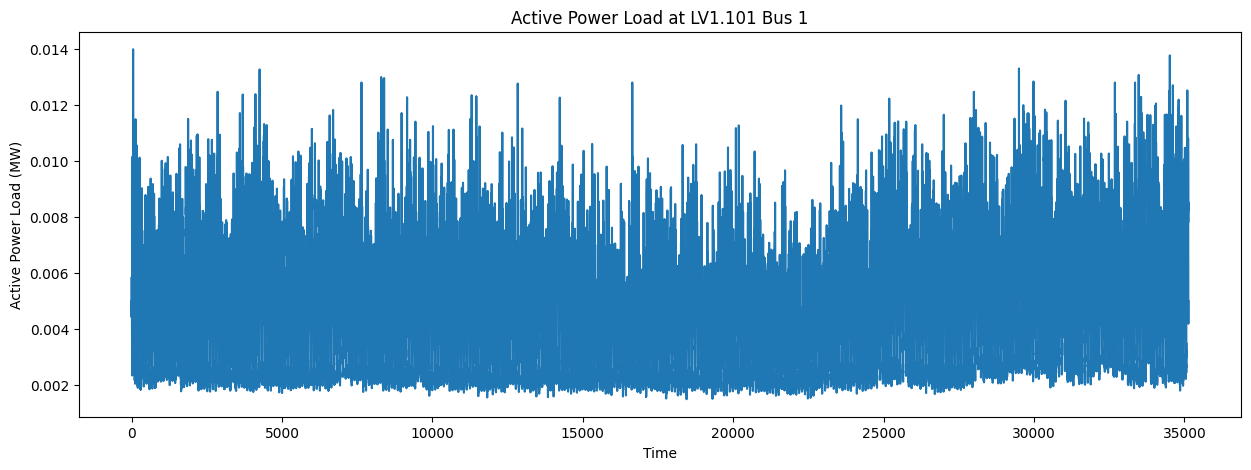

In [43]:
# Plot the attribute of the node LV1.101 Bus 1
plt.figure(figsize=(15, 5))
plt.plot(list(G.nodes['LV1.101 Bus 1']['load_p'].values()))
plt.title('Active Power Load at LV1.101 Bus 1')
plt.xlabel('Time')
plt.ylabel('Active Power Load (MW)')
plt.show()

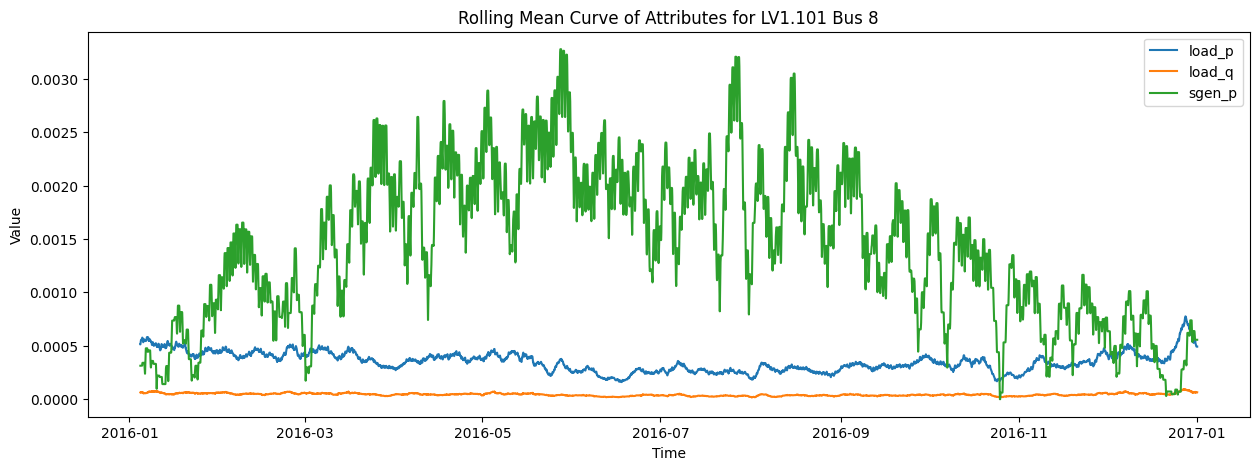

In [44]:
# Plot the rolling mean curve with a window of 7 days for all the attributes of the node LV1.101 Bus 8
plt.figure(figsize=(15, 5))
for key, value in G.nodes['LV1.101 Bus 8'].items():
    if isinstance(value, dict):
        rolling_mean = pd.Series(value).rolling(window=360).mean()
        plt.plot(rolling_mean, label=key)
plt.title('Rolling Mean Curve of Attributes for LV1.101 Bus 8')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Inspecting the Graph

In [45]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 15
Number of edges: 12


In [46]:
# Print a few nodes
print("Some nodes in the graph:", list(G.nodes())[:5])

# Print a few edges
print("Some edges in the graph:", list(G.edges())[:5])

Some nodes in the graph: ['LV1.101 Bus 1', 'LV1.101 Bus 2', 'LV1.101 Bus 3', 'LV1.101 Bus 4', 'LV1.101 Bus 5']
Some edges in the graph: [('LV1.101 Bus 1', 'LV1.101 Bus 8'), ('LV1.101 Bus 1', 'LV1.101 Bus 3'), ('LV1.101 Bus 2', 'LV1.101 Bus 9'), ('LV1.101 Bus 3', 'LV1.101 Bus 6'), ('LV1.101 Bus 3', 'LV1.101 Bus 7')]


In [47]:
net.line

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service,subnet,max_loading_percent,voltLvl
0,LV1.101 Line 1,NAYY 4x150SE 0.6/1kV,9,2,0.055767,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
1,LV1.101 Line 2,NAYY 4x150SE 0.6/1kV,13,11,0.053576,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
2,LV1.101 Line 3,NAYY 4x150SE 0.6/1kV,6,3,0.049814,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
3,LV1.101 Line 4,NAYY 4x150SE 0.6/1kV,8,1,0.017886,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
4,LV1.101 Line 5,NAYY 4x150SE 0.6/1kV,7,10,0.016089,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
5,LV1.101 Line 6,NAYY 4x150SE 0.6/1kV,10,9,0.024766,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
6,LV1.101 Line 7,NAYY 4x150SE 0.6/1kV,3,7,0.005141,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
7,LV1.101 Line 8,NAYY 4x150SE 0.6/1kV,11,6,0.002147,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
8,LV1.101 Line 9,NAYY 4x150SE 0.6/1kV,5,13,0.137215,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7
9,LV1.101 Line 10,NAYY 4x150SE 0.6/1kV,3,0,0.132499,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,LV1.101,100.0,7


# Add a new edge with goes from Bus 3 to Bus 14
G.add_edge('LV1.101 Bus 3', 'LV1.101 Bus 14')

# Add a new edge with goes from Bus 14 to Bus 4
G.add_edge('LV1.101 Bus 14', 'MV1.101 Bus 4')

In [48]:
# Add a new edge with goes from the bus with the most connections to the bus with 0 connections and the same prefix (e.g. LV1)
bus_with_most_connections = max(dict(G.degree()).items(), key=lambda x: x[1])[0]
bus_with_most_connections

# Find the bus with 0 connections
bus_with_0_connections = None
for node, degree in dict(G.degree()).items():
    if degree == 0 and node.startswith('LV1'):
        bus_with_0_connections = node
        break
bus_with_0_connections

# Add the new edge
G.add_edge(bus_with_most_connections, bus_with_0_connections)


# Add a new edge from the previous bus with 0 connections to the only bus left with 0 connections (does not have to be the same prefix)
bus_with_0_connections_2 = None
for node, degree in dict(G.degree()).items():
    if degree == 0:
        bus_with_0_connections_2 = node
        break
bus_with_0_connections_2

# Add the new edge
G.add_edge(bus_with_0_connections, bus_with_0_connections_2)    



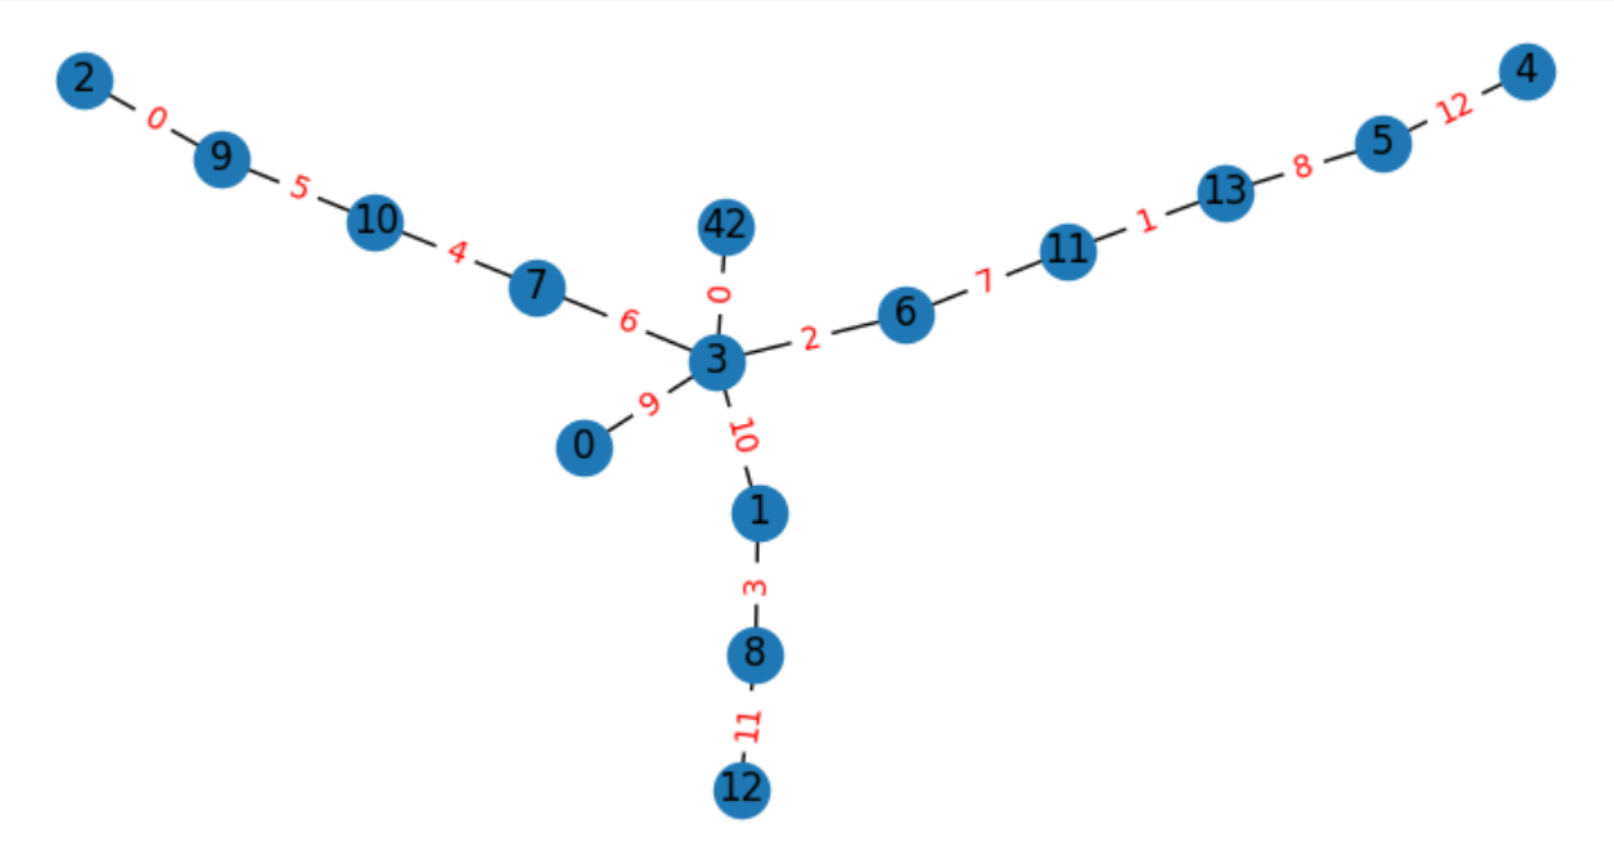

Verify that the attributes (e.g., time series data) have been correctly added to a specific node. You can do this by inspecting the attributes of one or more nodes, especially those to which you've added time series data.

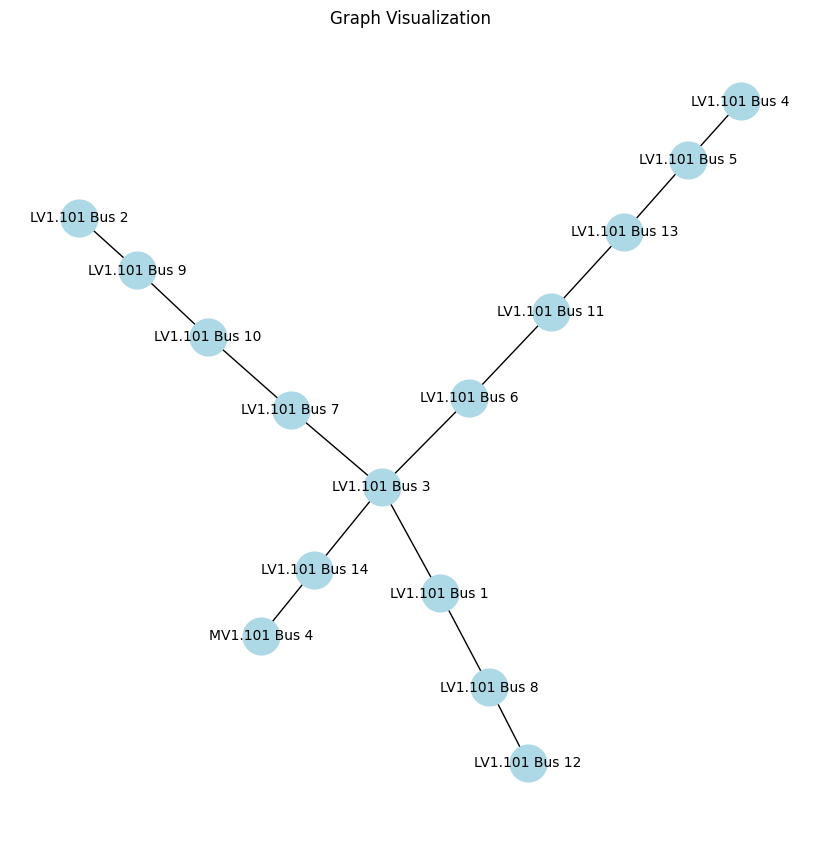

In [49]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=True, node_size=700, node_color="lightblue", font_size=10)
plt.title("Graph Visualization")
plt.show()

In [50]:
# Save the graph to a file
import pickle

# save graph object to file
pickle.dump(G, open('simbench_rural1_24hGraph.pickle', 'wb'))

# load graph object from file
G1 = pickle.load(open('simbench_rural1_24hGraph.pickle', 'rb'))

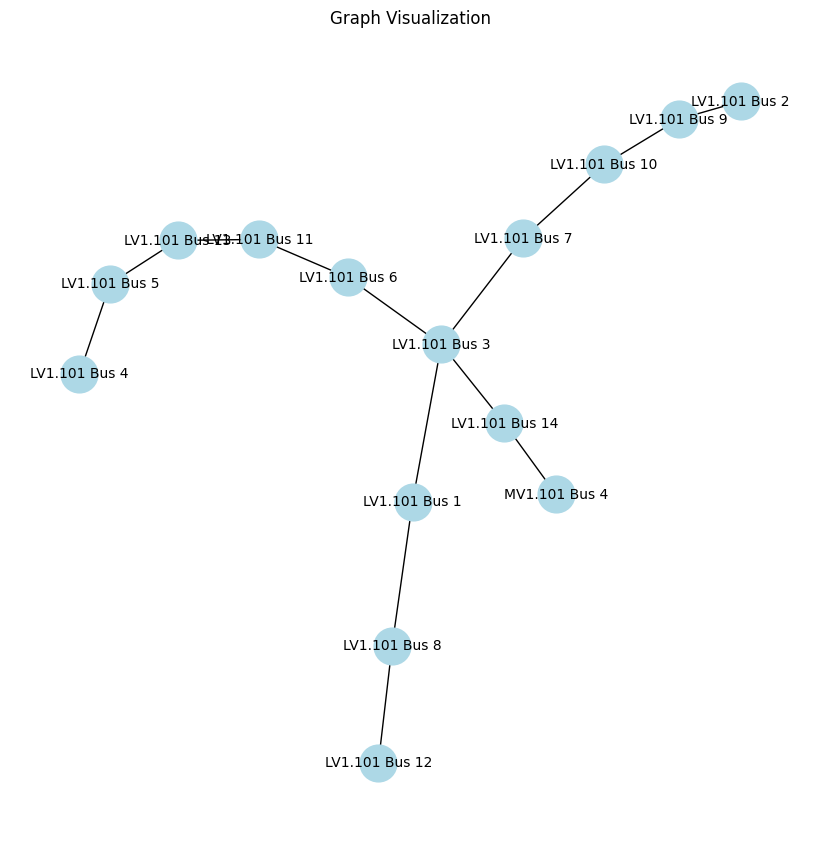

In [51]:
plt.figure(figsize=(8, 8))
nx.draw(G1, with_labels=True, node_size=700, node_color="lightblue", font_size=10)
plt.title("Graph Visualization")
plt.show()

In [52]:
# Create Spatio-Temporal Graph Convolutional Networks (STGCNs)

#adj_mat
adj_mat_array = np.array(adj_mat, dtype=np.float32)
adj_mat_array # Convert it to a NumPy array for later use

array([[0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.